In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'Angsana New'
rcParams.update({'font.size': 22})
rcParams['axes.unicode_minus'] = False

In [3]:
# df_read = pd.read_csv('data/corrected_data.csv')
df_read = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly.csv', parse_dates=["datetime"])

FileNotFoundError: [Errno 2] No such file or directory: 'data/chol-bangkla-corrected-2017-2022-hourly.csv'

In [4]:
# df_read = pd.read_csv('data/corrected_data.csv')
df_read = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly-corrected.csv', parse_dates=["datetime"])

In [5]:
df = df_read.copy()
print(df.dtypes)

datetime        datetime64[ns]
ec                     float64
ec_corrected           float64
dtype: object


In [6]:
df = df.sort_values(by=['datetime'])

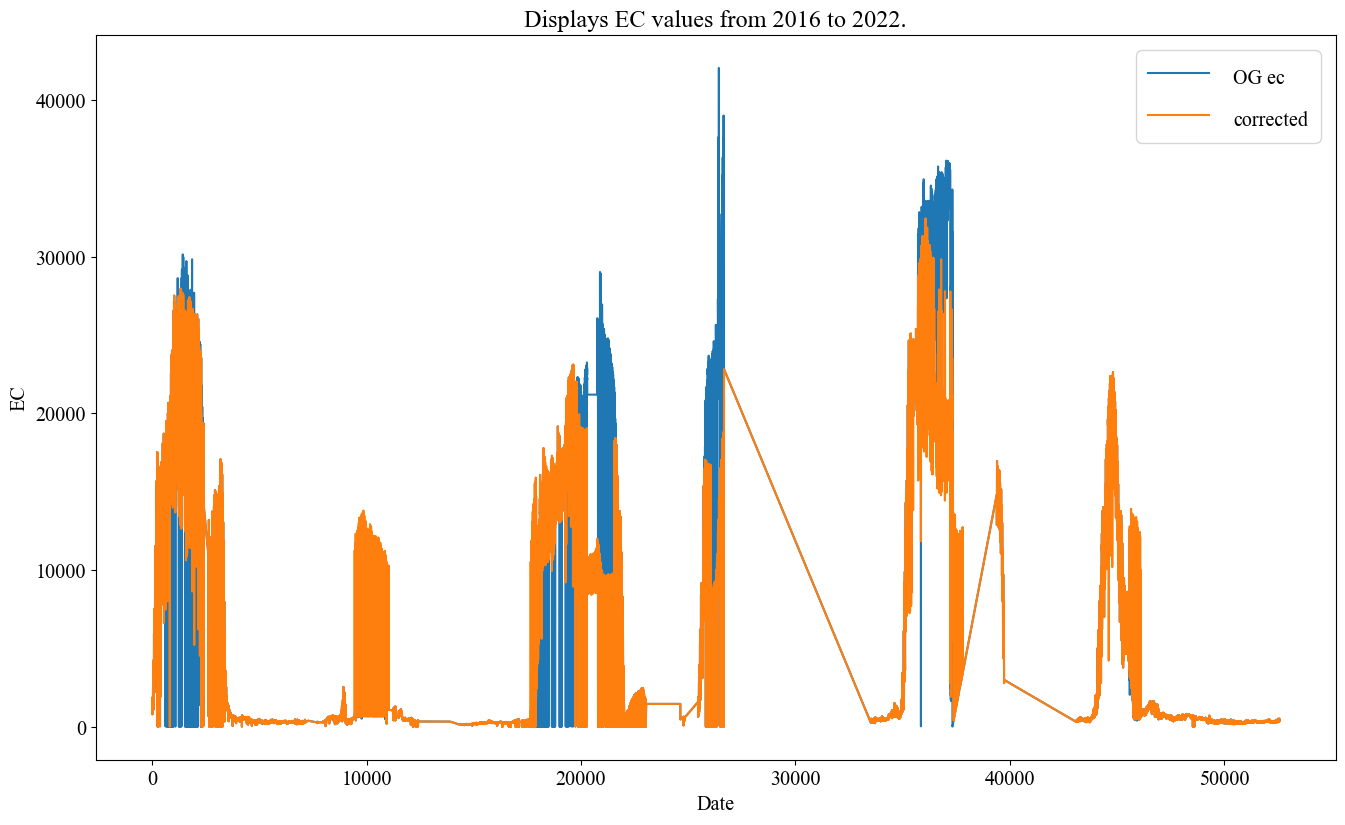

In [7]:
plt.figure(figsize=(16,32))
plt.subplot(3,1,1)
plt.title('Displays EC values from 2016 to 2022.')
plt.xlabel('Date')
plt.ylabel('EC')
plt.plot(df['ec'], label='OG ec')
plt.plot(df['ec_corrected'], label='corrected')
plt.legend()

# plt.subplot(3,1,2)
# plt.title('Displays Temp. values from March to September.')
# plt.xlabel('Date')
# plt.ylabel('°C')
# plt.plot(df['temperature'], label='OG temp.')
# plt.plot(df['temp_new_1'], label='temp_new_1')
# plt.plot(df['temp_new_2'], label='temp_new_2')
# plt.plot(df['temp_new_3'], label='temp_new_3')
# plt.plot(df['temp_new_4'], label='temp_new_4')
# plt.plot(df['temp_new_.5'], label='temp_new_.5')
# plt.legend()

# plt.subplot(3,1,3)
# plt.title('Displays pH. values from March to September.')
# plt.xlabel('Date')
# plt.ylabel('pH')
# plt.plot(df['pH'], label='OG pH')
# plt.plot(df['pH_new_1'], label='pH_new_1')
# plt.plot(df['pH_new_2'], label='pH_new_2')
# plt.plot(df['pH_new_3'], label='pH_new_3')
# plt.plot(df['pH_new_4'], label='pH_new_4')
# plt.plot(df['pH_new_.5'], label='pH_new_.5')
# plt.legend()

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [9]:
# =============================================================================
# MinMaxScaler
# =============================================================================

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

dataset_scaled = scaler.fit_transform(dataset)

NameError: name 'dataset' is not defined

In [10]:
# =============================================================================
# กำหนดตัวแปรที่ต้องการใช้ train ตัว model
# =============================================================================

data = df.filter(['ec_corrected'])
dataset = data.values

In [11]:
# =============================================================================
# MinMaxScaler
# =============================================================================

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

dataset_scaled = scaler.fit_transform(dataset)

In [12]:
n_future = 24
n_past = 48

In [13]:
# import math

# train_set_len = math.ceil(len(dataset) * 0.80)
# valid_set_len = math.ceil(len(dataset) * 0.10)

# first 3yrs
train_set_len = 26280

# last year
valid_set_len = 17544

In [14]:
# train_set = dataset_scaled[0:train_set_len, :]
train_set = dataset_scaled[0:train_set_len -1, :]


x_train = []
y_train = []

for i in range(n_past, len(train_set) - n_future + 1):
    x_train.append(train_set[i - n_past:i, 0:dataset.shape[1]])
    y_train.append(train_set[i + n_future - 1:i + n_future, 0])

In [15]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [16]:
valid_set = dataset_scaled[train_set_len - n_past:train_set_len + valid_set_len, :]

x_valid = []
y_valid = []

for i in range(n_past, len(valid_set) - n_future + 1):
    x_valid.append(valid_set[i - n_past:i, 0:dataset.shape[1]])
    y_valid.append(valid_set[i + n_future - 1:i + n_future, 0])

In [17]:
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [18]:
test_set = dataset_scaled[(train_set_len + valid_set_len) - n_past:, :]
test_real = dataset[(train_set_len + valid_set_len) - n_past:, :]

x_test = []
y_test = []

for i in range(n_past, len(test_set) - n_future + 1):
    x_test.append(test_set[i - n_past:i, 0:dataset.shape[1]])
    y_test.append(test_real[i + n_future - 1:i + n_future, 0])

In [19]:
x_test, y_test = np.array(x_test), np.array(y_test)

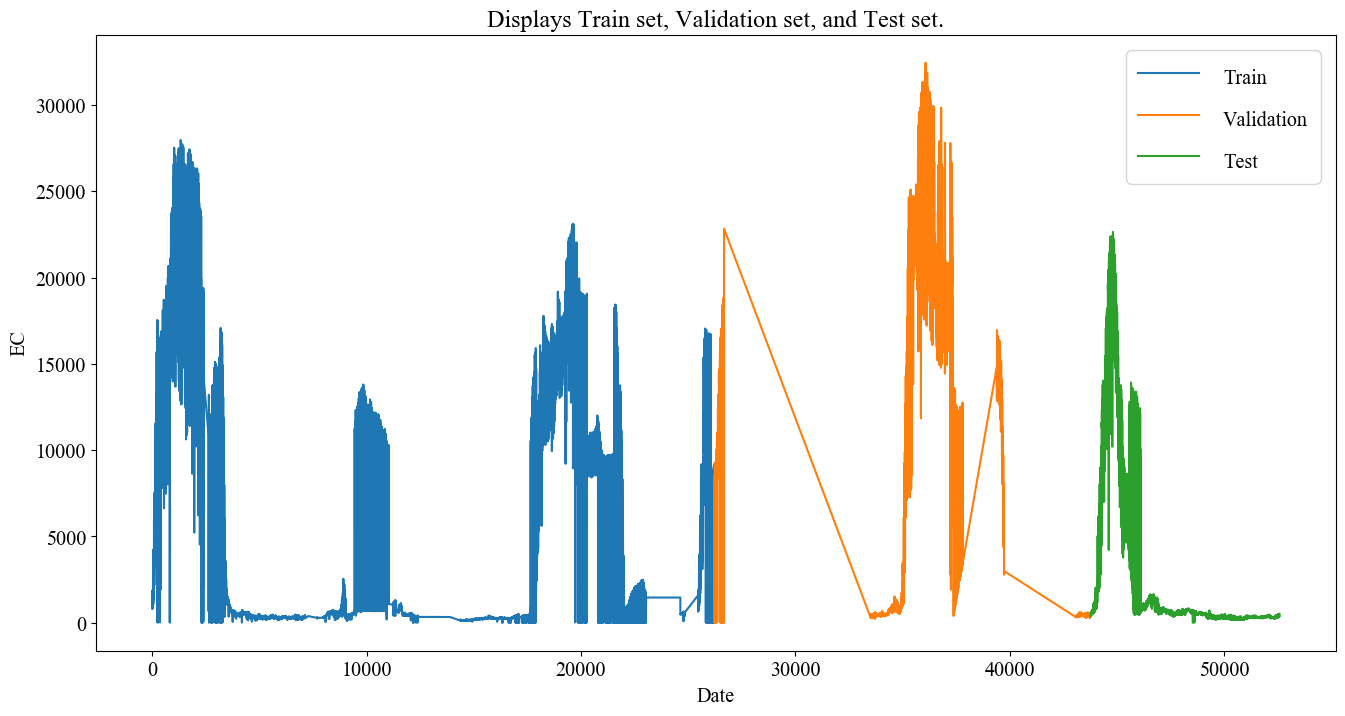

In [20]:
plt.figure(figsize=(16,8))
plt.title('Displays Train set, Validation set, and Test set.')
plt.xlabel('Date')
plt.ylabel('EC')
plt.plot(df[0:train_set_len]["ec_corrected"], label='Train')
plt.plot(df[train_set_len - n_past:train_set_len + valid_set_len]["ec_corrected"], label='Validation')
plt.plot(df[(train_set_len + valid_set_len) - n_past:]["ec_corrected"], label='Test')
plt.legend()
plt.show()

In [21]:
from keras import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
# from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
# from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
# =============================================================================
# RNN
# =============================================================================

model = Sequential()
model.add(SimpleRNN(192, return_sequences=True, input_shape=(n_past,1)))
model.add(SimpleRNN(96, return_sequences=True))
model.add(SimpleRNN(48, return_sequences=False))
model.add(Dense(n_future))

# model.add(SimpleRNN(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(SimpleRNN(64, return_sequences=True))
# model.add(SimpleRNN(64, return_sequences=False))
# model.add(Dense(16))
# model.add(Dense(1))

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 48, 192)           37248     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 48, 96)            27744     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 48)                6960      
                                                                 
 dense (Dense)               (None, 24)                1176      
                                                                 
Total params: 73,128
Trainable params: 73,128
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 48, 192)           37248     
                                                                 
 simple_rn

In [24]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [25]:
checkpoint_filepath = 'checkpoint/01-rnn-24-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [26]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1090/1092 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 1: val_loss improved from inf to 0.00174, saving model to checkpoint\01-rnn-24-3-2-1.h5
1092/1092 [==============================] - 28s 25ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 2/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 2: val_loss did not improve from 0.00174
1092/1092 [==============================] - 26s 24ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/128
1091/1092 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 3: val_loss did not improve from 0.00174
1092/1092 [==============================] - 26s 24ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031
Epoch 4: val_loss did not improve from 0.00174
1092/1092 [===

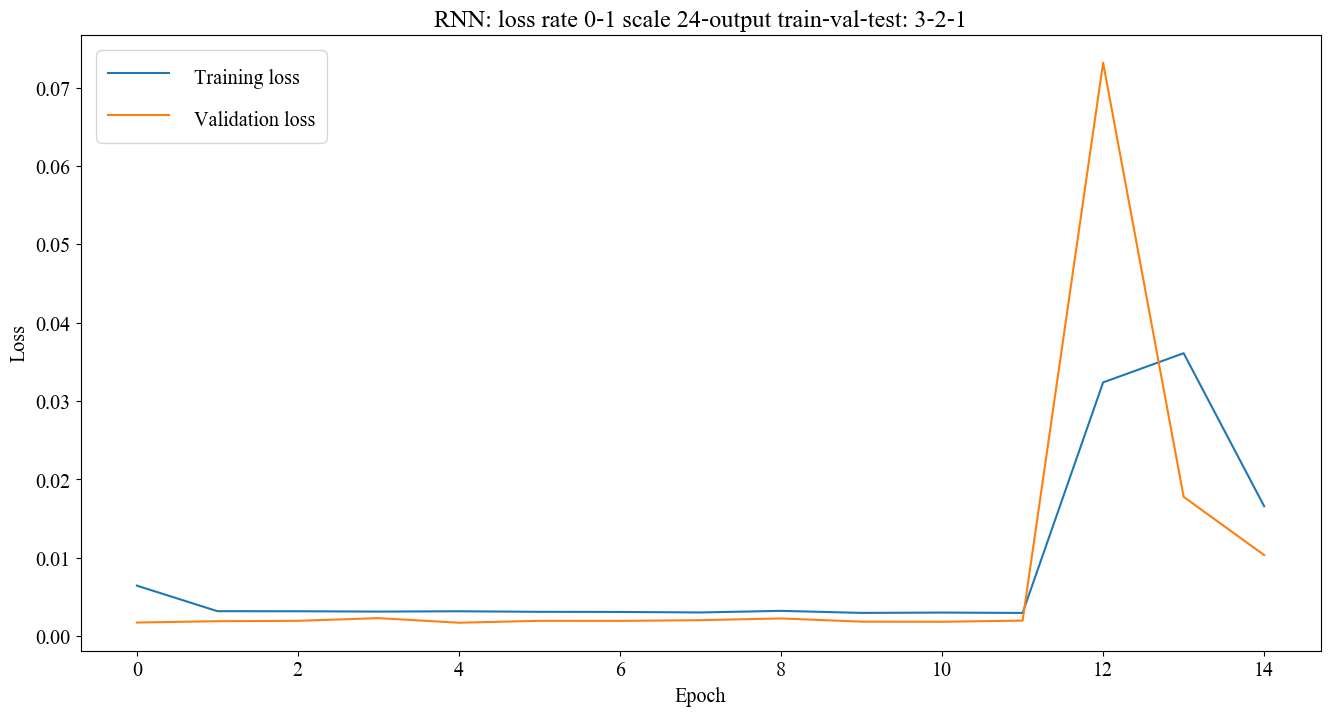

In [27]:
plt.figure(figsize=(16,8))
plt.title('RNN: loss rate 0-1 scale 24-output train-val-test: 3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [28]:
# =============================================================================
# RNN
# =============================================================================

model = Sequential()
model.add(SimpleRNN(192, return_sequences=True, input_shape=(n_past,1)))
model.add(SimpleRNN(96, return_sequences=True))
model.add(SimpleRNN(48, return_sequences=False))
model.add(Dense(n_future))

# model.add(SimpleRNN(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(SimpleRNN(64, return_sequences=True))
# model.add(SimpleRNN(64, return_sequences=False))
# model.add(Dense(16))
# model.add(Dense(1))

In [29]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 48, 192)           37248     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 48, 96)            27744     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 48)                6960      
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 48, 192)           37248     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 48, 96)           

In [30]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15)

In [31]:
checkpoint_filepath = 'checkpoint/01-rnn-24-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [32]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1090/1092 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 0.0059
Epoch 1: val_loss improved from inf to 0.00174, saving model to checkpoint\01-rnn-24-3-2-1.h5
1092/1092 [==============================] - 28s 25ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 2/128
1090/1092 [============================>.] - ETA: 0s - loss: 0.0033 - mse: 0.0033
Epoch 2: val_loss improved from 0.00174 to 0.00170, saving model to checkpoint\01-rnn-24-3-2-1.h5
1092/1092 [==============================] - 27s 24ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 3/128
1091/1092 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 3: val_loss did not improve from 0.00170
1092/1092 [==============================] - 27s 25ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 4: v

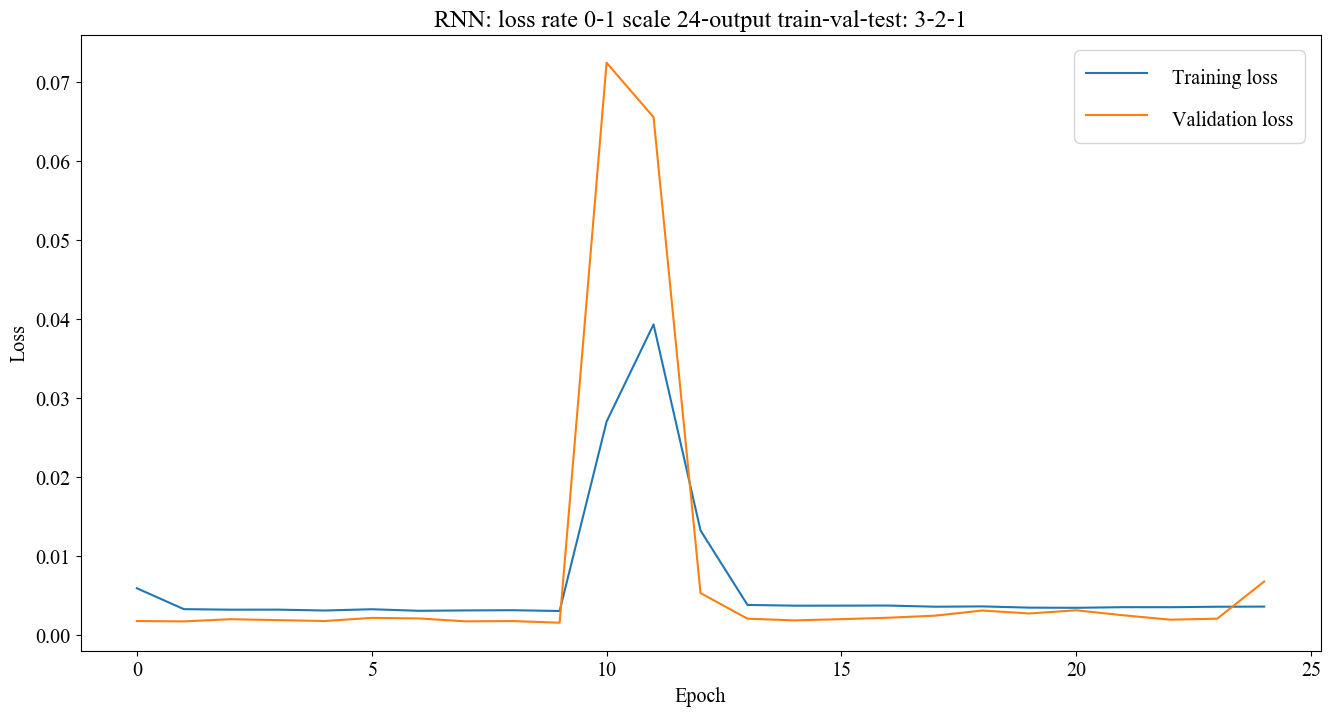

In [33]:
plt.figure(figsize=(16,8))
plt.title('RNN: loss rate 0-1 scale 24-output train-val-test: 3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [34]:
# =============================================================================
# RNN
# =============================================================================

model = Sequential()
model.add(SimpleRNN(192, return_sequences=True, input_shape=(n_past,1)))
model.add(SimpleRNN(96, return_sequences=True))
model.add(SimpleRNN(48, return_sequences=False))
model.add(Dense(n_future))

# model.add(SimpleRNN(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(SimpleRNN(64, return_sequences=True))
# model.add(SimpleRNN(64, return_sequences=False))
# model.add(Dense(16))
# model.add(Dense(1))

In [35]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 48, 192)           37248     
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 48, 96)            27744     
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 48)                6960      
                                                                 
 dense_2 (Dense)             (None, 24)                1176      
                                                                 
Total params: 73,128
Trainable params: 73,128
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 48, 192)           37248     
                                                                 
 simple_

In [36]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [37]:
checkpoint_filepath = 'checkpoint/01-rnn-24-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [38]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 1: val_loss improved from inf to 0.00166, saving model to checkpoint\01-rnn-24-3-2-1.h5
1092/1092 [==============================] - 28s 24ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 2/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033
Epoch 2: val_loss did not improve from 0.00166
1092/1092 [==============================] - 26s 24ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 3/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 3: val_loss improved from 0.00166 to 0.00158, saving model to checkpoint\01-rnn-24-3-2-1.h5
1092/1092 [==============================] - 26s 24ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 4/128
1090/1092 [============================>.] - ETA: 0s - loss: 0.0031 - mse: 0.0031
Epoch 4: v

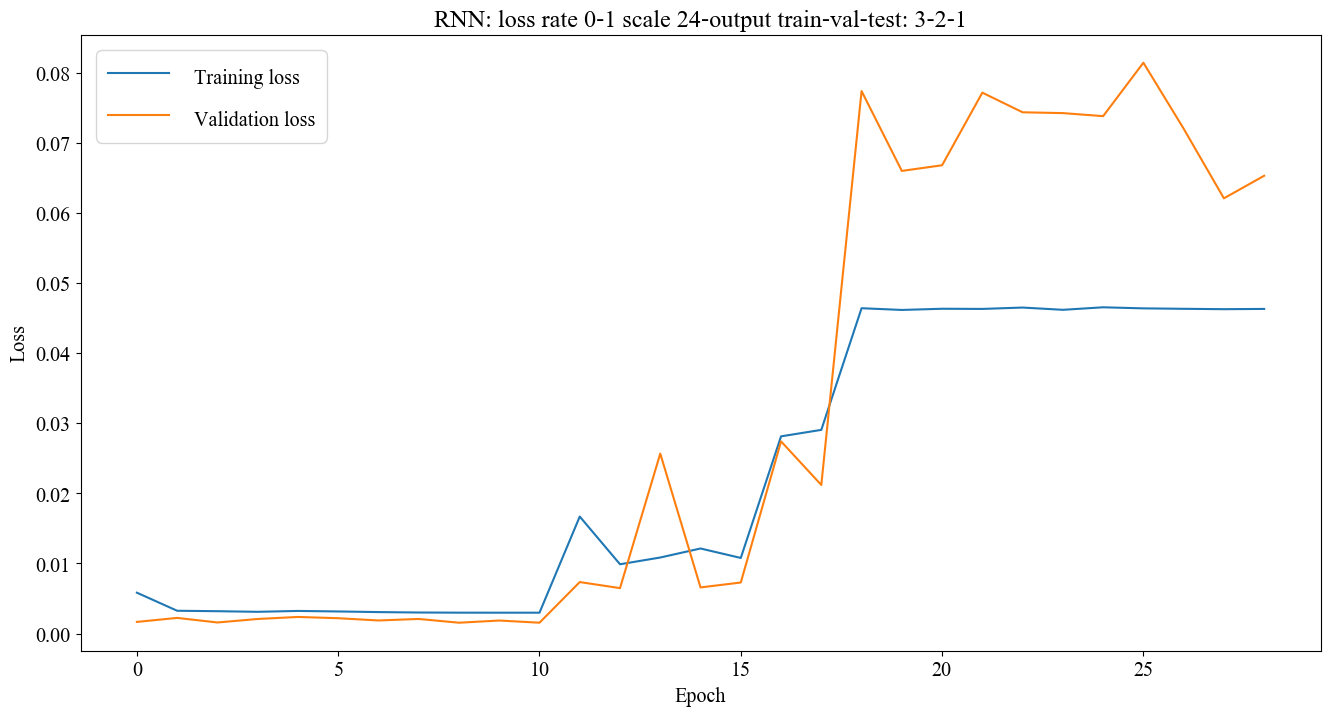

In [39]:
plt.figure(figsize=(16,8))
plt.title('RNN: loss rate 0-1 scale 24-output train-val-test: 3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [40]:
from keras.models import load_model

model = load_model('checkpoint/01-rnn-24-3-2-1.h5')

In [41]:
pred = model.predict(x_test)

274/274 [==============================] - 3s 9ms/step


In [42]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [43]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [44]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [45]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE of RNN = {rmse}')            

RMSE of RNN = 1252.7287068306975


In [47]:
from sklearn.metrics import mean_absolute_percentage_error

# calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE of RNN = {mape}')

MAPE of RNN = 0.7356039984864473


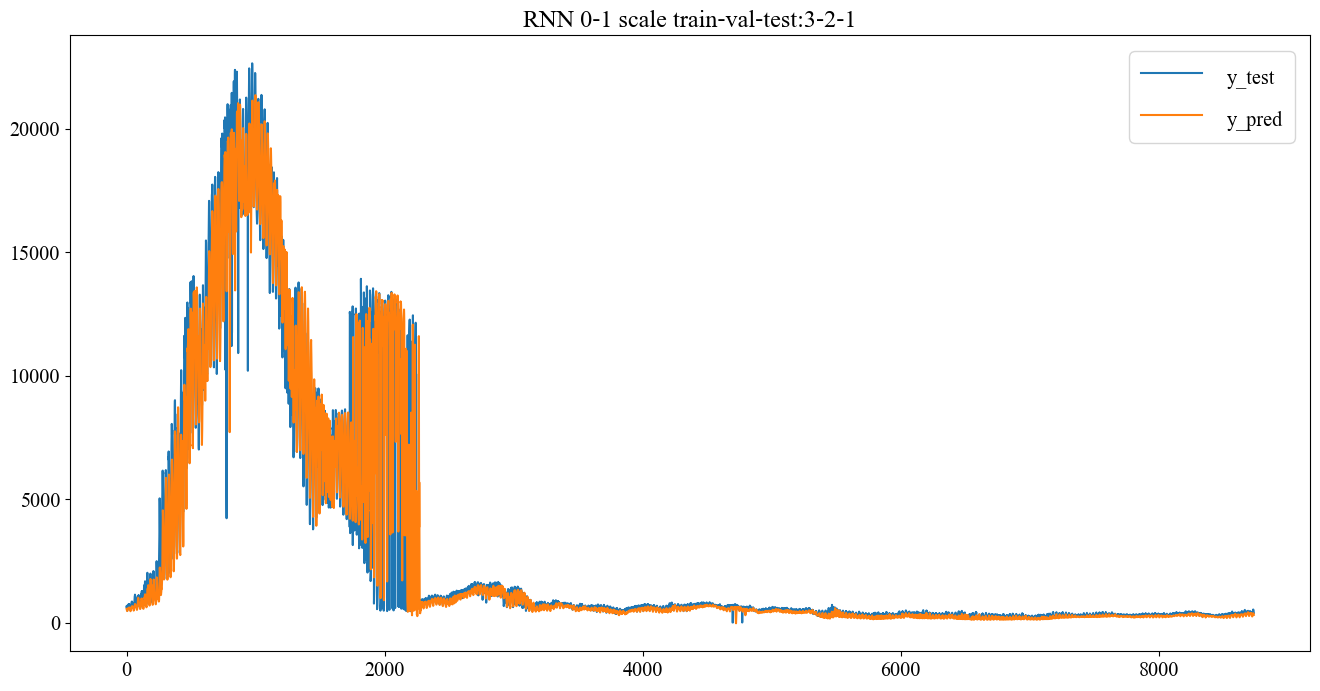

In [48]:
plt.figure(figsize=(16,8))
plt.title('RNN 0-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [49]:
# =============================================================================
# LSTM
# =============================================================================

model = Sequential()
model.add(LSTM(192, return_sequences=True, input_shape=(n_past,1)))
model.add(LSTM(96, return_sequences=True))
model.add(LSTM(48, return_sequences=False))
model.add(Dense(n_future))

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(n_future))
# model.add(Dense(16))
# model.add(Dense(1))

In [50]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 192)           148992    
                                                                 
 lstm_1 (LSTM)               (None, 48, 96)            110976    
                                                                 
 lstm_2 (LSTM)               (None, 48)                27840     
                                                                 
 dense_3 (Dense)             (None, 24)                1176      
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 192)           148992    
                                                                 
 lstm_1 (LSTM)               (None, 48, 96)           

In [51]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [52]:
checkpoint_filepath = 'checkpoint/01-lstm-24-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [53]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048
Epoch 1: val_loss improved from inf to 0.00181, saving model to checkpoint\01-lstm-24-3-2-1.h5
1092/1092 [==============================] - 75s 66ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029
Epoch 2: val_loss improved from 0.00181 to 0.00159, saving model to checkpoint\01-lstm-24-3-2-1.h5
1092/1092 [==============================] - 72s 66ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 3/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029
Epoch 3: val_loss improved from 0.00159 to 0.00158, saving model to checkpoint\01-lstm-24-3-2-1.h5
1092/1092 [==============================] - 74s 68ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 4/128
1092/1092 [===========================

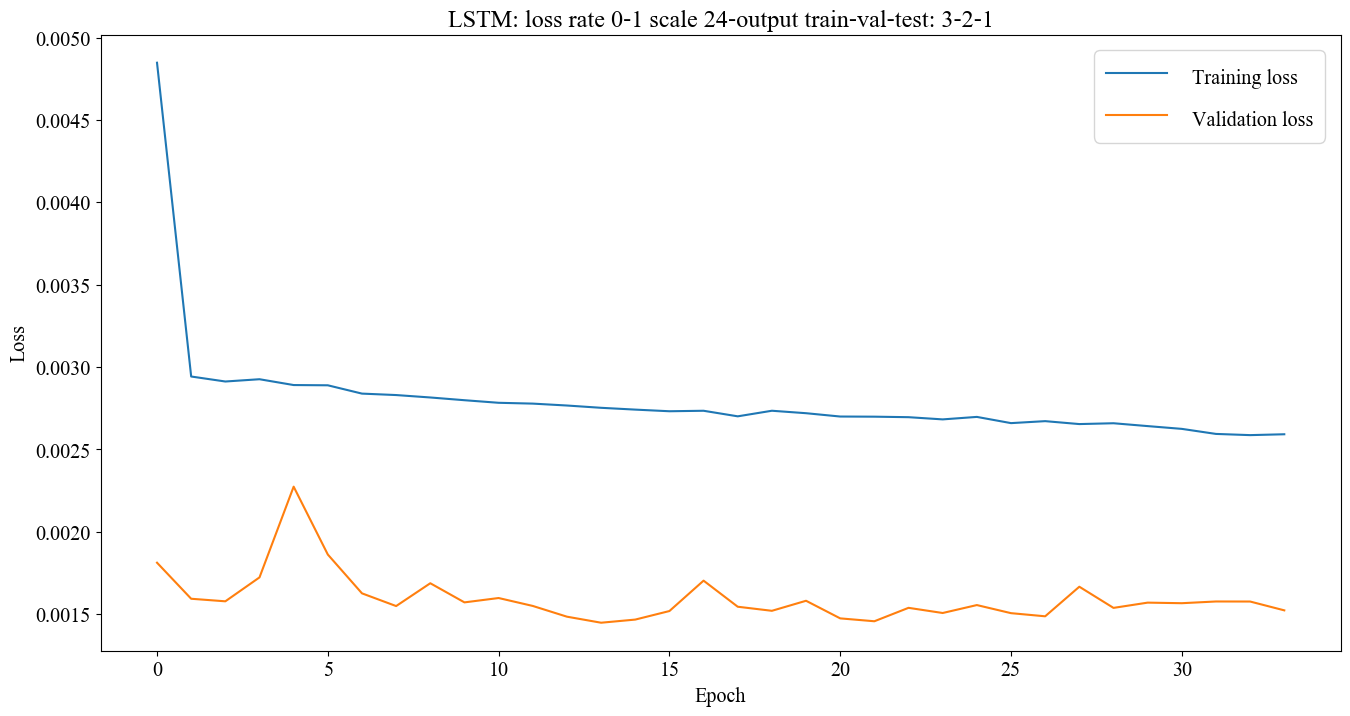

In [54]:
plt.figure(figsize=(16,8))
plt.title('LSTM: loss rate 0-1 scale 24-output train-val-test: 3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [55]:
from keras.models import load_model

model = load_model('checkpoint/01-lstm-24-3-2-1.h5')

In [56]:
pred = model.predict(x_test)

274/274 [==============================] - 8s 27ms/step


In [57]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [58]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [59]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [60]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE of LSTM = {rmse}')            

RMSE of LSTM = 1248.0641107207246


In [61]:
from sklearn.metrics import mean_absolute_percentage_error

# calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE of LSTM = {mape}')

MAPE of LSTM = 0.7581087754126519


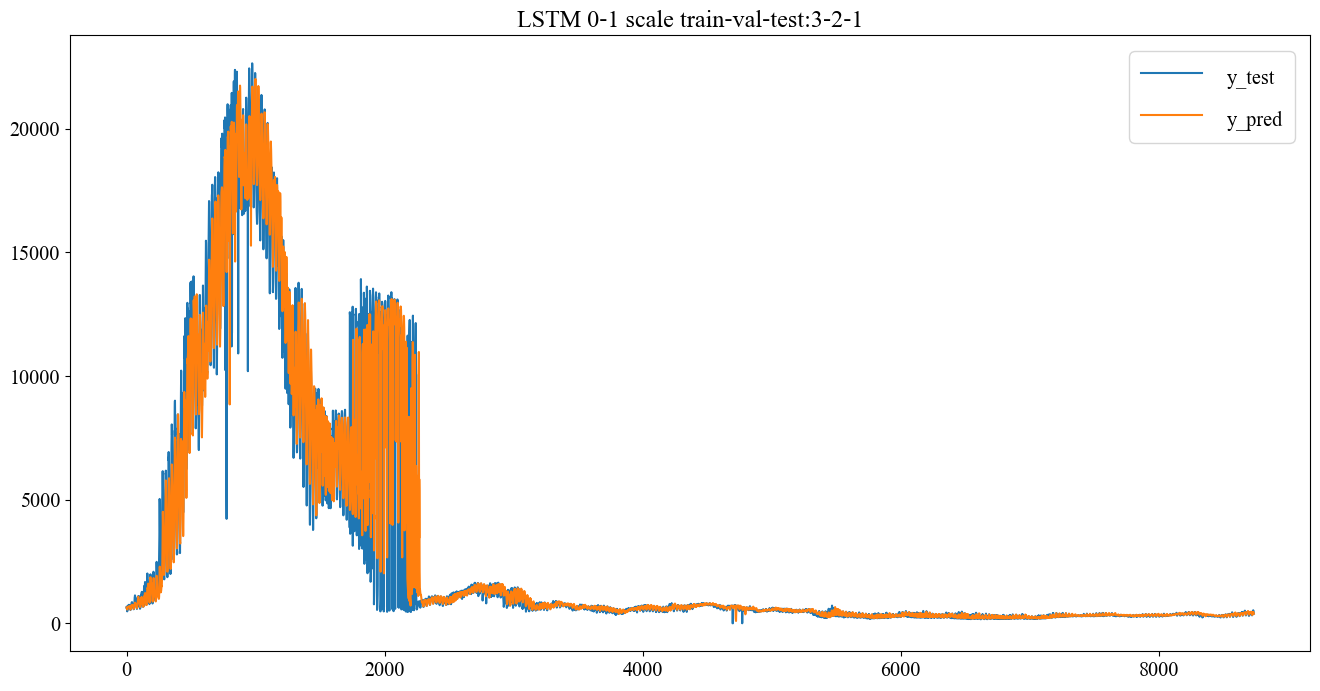

In [62]:
plt.figure(figsize=(16,8))
plt.title('LSTM 0-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [63]:
# =============================================================================
# Bidirectional LSTM
# =============================================================================

model = Sequential()
model.add(Bidirectional(LSTM(192, return_sequences=True), input_shape=(n_past,1)))
model.add(Bidirectional(LSTM(96, return_sequences=True)))
model.add(Bidirectional(LSTM(48, return_sequences=False)))
model.add(Dense(n_future))

# model.add(Dense(16))
# model.add(Dense(1))

In [64]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 384)          297984    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 48, 192)          369408    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 96)               92544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                2328      
                                                                 
Total params: 762,264
Trainable params: 762,264
_________________________________________________________________
 Layer

In [65]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [66]:
checkpoint_filepath = 'checkpoint/01-bilstm-24-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [67]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0038
Epoch 1: val_loss improved from inf to 0.00159, saving model to checkpoint\01-bilstm-24-3-2-1.h5
1092/1092 [==============================] - 149s 131ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 2/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030
Epoch 2: val_loss did not improve from 0.00159
1092/1092 [==============================] - 155s 142ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 3/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029
Epoch 3: val_loss did not improve from 0.00159
1092/1092 [==============================] - 161s 147ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/128
1092/1092 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029
Epoch 4: val_loss improved from 0.00159 to 0.00154, 

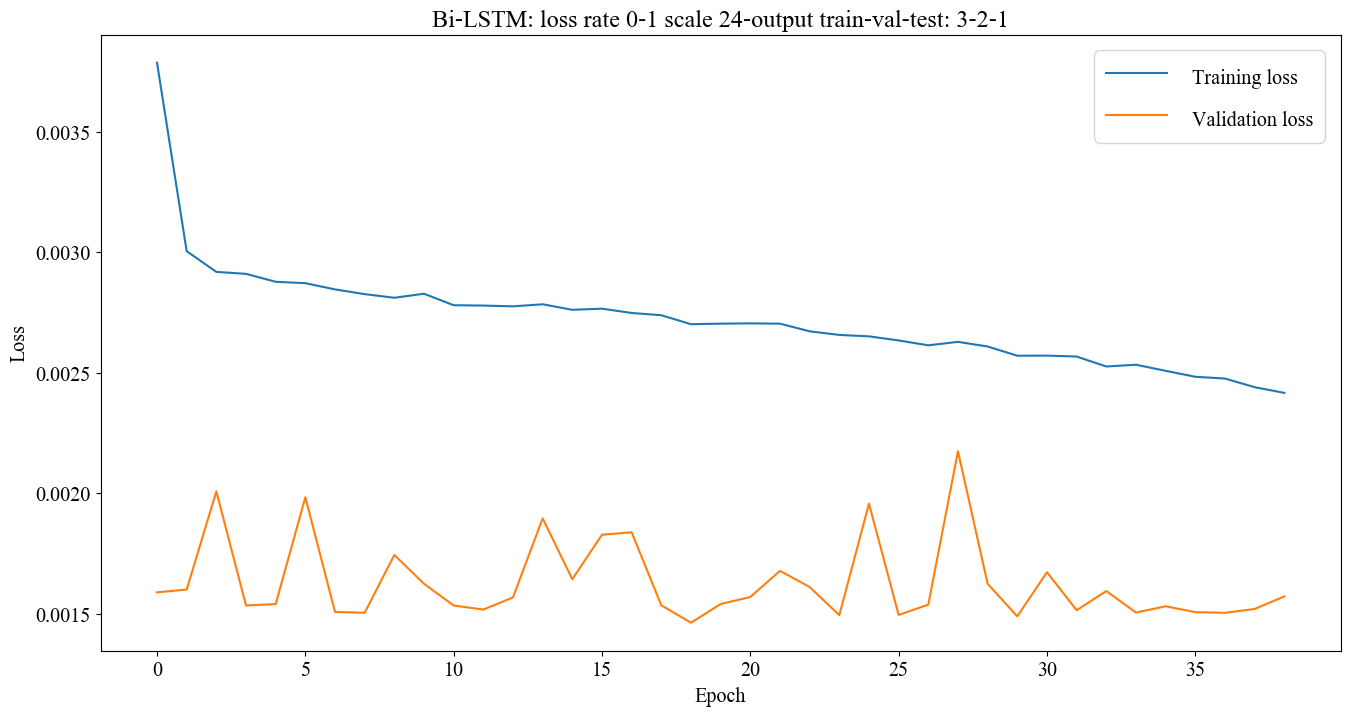

In [68]:
plt.figure(figsize=(16,8))
plt.title('Bi-LSTM: loss rate 0-1 scale 24-output train-val-test: 3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [69]:
from keras.models import load_model

model = load_model('checkpoint/01-bilstm-24-3-2-1.h5')

In [70]:
pred = model.predict(x_test)

274/274 [==============================] - 19s 62ms/step


In [71]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [72]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [73]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [74]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE of Bi-LSTM = {rmse}')            

RMSE of Bi-LSTM = 1258.1250623581261


In [75]:
from sklearn.metrics import mean_absolute_percentage_error

# calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE of Bi-LSTM = {mape}')

MAPE of Bi-LSTM = 0.9473795148203812


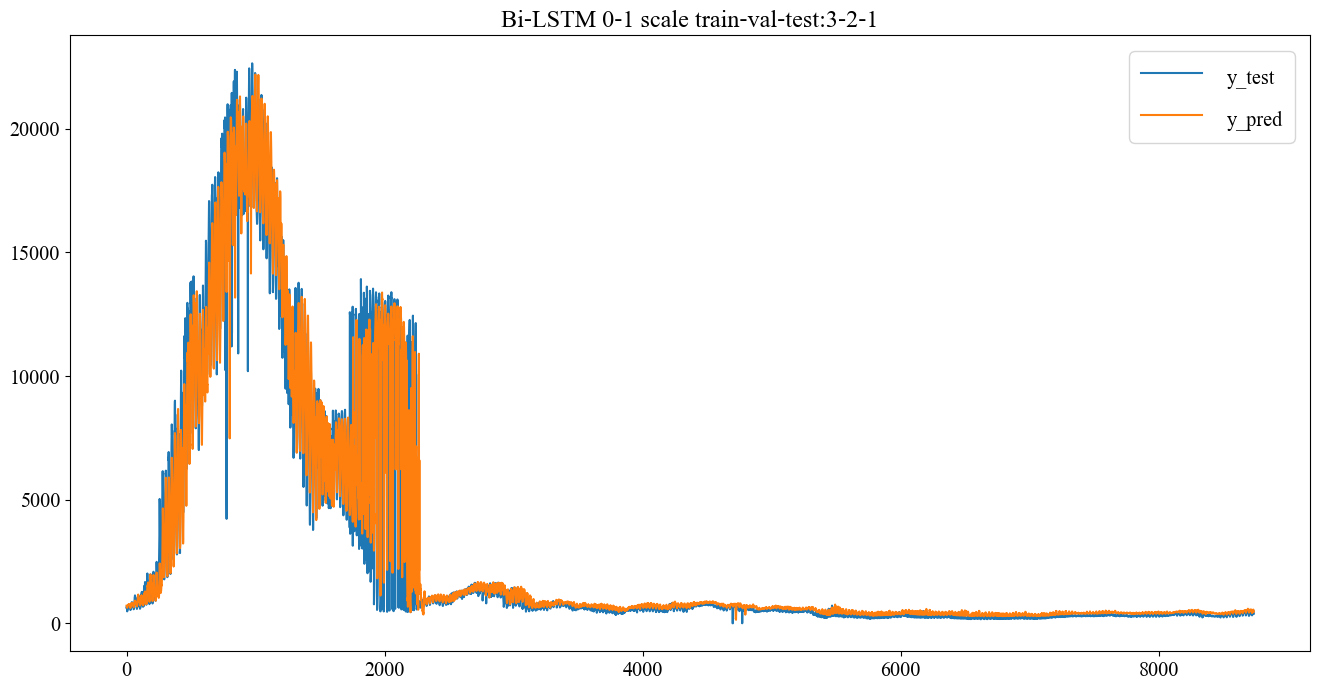

In [76]:
plt.figure(figsize=(16,8))
plt.title('Bi-LSTM 0-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()